In [1]:
import sys
import numpy as np
from scipy.spatial import ConvexHull
from scipy import sparse
import pandas as pd
from sklearn.manifold import MDS #If you want the scikit learn mds
import HiCtoolbox
import pandas as pd
from hmmlearn import hmm

In [2]:
R=100000        # here you write resolution 
NbmaxEpi=15    #Epi states go from 0 to 15
alpha=0.227    
selectedmark=1  #index of the selected mark

#EpiGfilename='E116_15.bed' 

In [3]:
#Building the chromosomal contacts matrix

ch1=pd.read_csv("chr22_100kb.txt", sep="\t",header=None)    # <-  here  acces to data ,write the filename you wish  
A=np.int_(np.array(ch1))

A=np.concatenate((A,np.transpose(np.array([A[:,1],A[:,0],A[:,2]]))), axis=0)#flipping rows to keep full data  @ taken from Leopold

A= sparse.coo_matrix( (A[:,2], (A[:,0],A[:,1]))) # need sparse becaus eof big volume of some matrices


binned_map=HiCtoolbox.bin2d(A,R,R) #!become csr sparse array, taken from leopold

del A#keep space


In [4]:
#filtering taken from Leopold

print("before filtering : ",np.shape(binned_map))
sumHicmat=np.sum(binned_map,0) 
mini = np.mean(sumHicmat)-np.std(sumHicmat)*1.5 #min value of filtering
maxi = np.mean(sumHicmat)+np.std(sumHicmat)*1.5 #max value of filtering
binsaved=np.where(np.logical_and(mini < sumHicmat,sumHicmat < maxi)) #coord of bin to save
filtered_map=binned_map[binsaved[1],:] #save on raw
filtered_map=filtered_map[:,binsaved[1]] #save on col why? 

print("after filtering : ",np.shape(filtered_map))


before filtering :  (513, 513)
after filtering :  (511, 511)


In [5]:
# SCN
contact_map=HiCtoolbox.SCN(filtered_map.copy()) 
#contact_map=np.asarray(contact_map)**alpha #  to not be in sparse matrix


In [6]:
# division by mean of diagonal passing by point (i,j) ,sometimes it takes a time
d=[]    # diagonal
for j in range(contact_map.shape[0]):
    diagonals=[]
    for i in range(contact_map.shape[0]-j):
        diagonals.append(contact_map[i+j,i])
        mean=np.mean(diagonals)
        
        
    d.append(mean)
d

[0.26399019444223976,
 0.04231428833411247,
 0.020721240209220997,
 0.013964619520705452,
 0.010172184765330298,
 0.007910398792779426,
 0.006162141058164032,
 0.00507702684225111,
 0.004227639331190253,
 0.0036477643280542014,
 0.003154282714614843,
 0.002796534483876005,
 0.002535605996818155,
 0.002199897065021385,
 0.0019266239939486442,
 0.0017429791644929975,
 0.0015273789865032283,
 0.0014295866243050472,
 0.0013150361370899484,
 0.0011966182322969074,
 0.001118335488596431,
 0.0010859698694092351,
 0.0010224523369285325,
 0.0009122285955011412,
 0.0008661718246192687,
 0.0008256435575019829,
 0.0008066782541272972,
 0.00079620467648471,
 0.0007008676226148629,
 0.0006783646309490323,
 0.0006582519006678916,
 0.000611594270535697,
 0.0006077749668835026,
 0.0005839660574474629,
 0.000572860897874745,
 0.0005212842460658642,
 0.0005361885284656966,
 0.0005173432457067147,
 0.0005044335501225975,
 0.00045973343104366787,
 0.000441079381536855,
 0.0004310530238772004,
 0.0004103869

In [7]:
# division by mean of diagonal passing by point (i,j) ,sometimes it takes a time
for j in range(contact_map.shape[0]):
    for i in range(contact_map.shape[0]):
        if d[abs(j-i)]!=0:
            contact_map[i,j]=contact_map[i,j]/d[abs(j-i)]
            
contact_map

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.61262204, 1.66752345,
         1.94759601],
        [0.        , 0.        , 0.        , ..., 1.66752345, 1.90904671,
         1.86552483],
        [0.        , 0.        , 0.        , ..., 1.94759601, 1.86552483,
         0.20657047]])

In [8]:
# remove the diagonals, not sure if necessary
contact_map=contact_map-np.diag(np.diag(contact_map)) # 

In [9]:
# visualisation of chromosomal matrix , not to confuse with correlations
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

<AxesSubplot:>

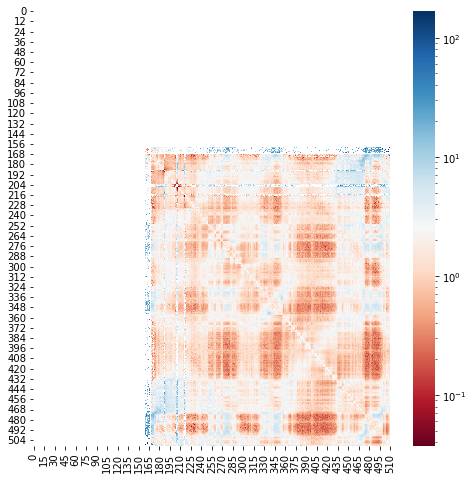

In [10]:
plt.figure(figsize=(8, 8)) 
sns.heatmap(contact_map, norm=LogNorm(),cmap="RdBu")

In [11]:
# calculating correlations by hand  point by point
from scipy import stats
contact_map=np.array(contact_map)

hand_corr=np.zeros((contact_map.shape[0],contact_map.shape[0]))
for i in range(contact_map.shape[0]):
    for j in range(contact_map.shape[0]):
        corr=stats.pearsonr(contact_map[i,:],contact_map[:,j]) # preason correlation
        hand_corr[i,j]=corr[0]
hand_corr=np.nan_to_num(hand_corr, nan=0.0) # replacing Nan by zeros
hand_corr


C:\Users\oktaw\anaconda\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.01874534, -0.01158219],
       [ 0.        ,  0.        ,  0.        , ...,  0.01874534,
         1.        ,  0.06480461],
       [ 0.        ,  0.        ,  0.        , ..., -0.01158219,
         0.06480461,  1.        ]])

In [11]:
# caluclating correlations quickly correlations

corr_mat=np.corrcoef(np.array(contact_map)) # calcul of Pearson correlation
corr_mat=np.nan_to_num(corr_mat, nan=0.0) # replacing Nan by zeros


C:\Users\oktaw\anaconda\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\oktaw\anaconda\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<AxesSubplot:>

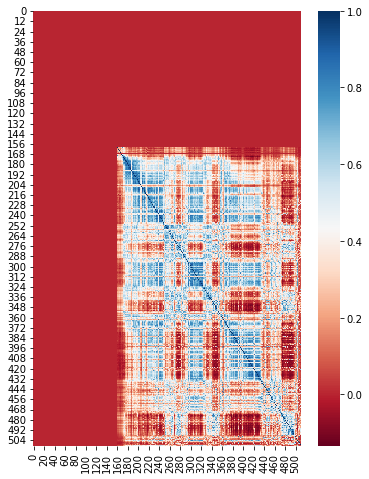

In [12]:
# visualisation of correlation
plt.figure(figsize=(6, 8)) 
#sns.color_palette("vlag", as_cmap=True)
#sns.diverging_palette(220, 20, as_cmap=True)
#sns.color_palette("coolwarm", as_cmap=True)
# = sns.color_palette("RdBu", 10)
sns.heatmap(corr_mat,cmap="RdBu")

In [19]:
# ANALYSIS 
# SVD
svd=np.linalg.svd(corr_mat)
svd [1]

array([1.35958033e+02, 4.99661288e+01, 1.82156794e+01, 1.44390830e+01,
       1.32854986e+01, 1.10763088e+01, 1.07884894e+01, 9.70296918e+00,
       8.12178406e+00, 7.68417175e+00, 7.21438015e+00, 6.43688923e+00,
       5.71286001e+00, 4.12618235e+00, 3.48563371e+00, 2.77788373e+00,
       2.58030906e+00, 2.45166803e+00, 2.30562597e+00, 2.07718163e+00,
       1.88746018e+00, 1.51656038e+00, 1.38302632e+00, 1.26711279e+00,
       1.22772248e+00, 1.09416624e+00, 1.05336953e+00, 9.50590492e-01,
       8.84027799e-01, 8.57380711e-01, 7.65444972e-01, 7.55092893e-01,
       7.41533871e-01, 6.51145506e-01, 6.35060629e-01, 6.06679643e-01,
       5.90701687e-01, 5.64463696e-01, 5.25696748e-01, 5.02091291e-01,
       4.64072027e-01, 4.22853041e-01, 4.15536306e-01, 4.01388420e-01,
       3.88223056e-01, 3.37544102e-01, 3.22142092e-01, 3.04575951e-01,
       2.90661777e-01, 2.76408815e-01, 2.64747541e-01, 2.47696111e-01,
       2.28197202e-01, 2.22967554e-01, 2.16568610e-01, 2.08692082e-01,
      

In [26]:
# eigenvectors
eigenvalue,eigenvector=np.linalg.eig(corr_mat)
eigenvector

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.01670275, -0.05133864,  0.06636934, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01608619, -0.02868355,  0.02391907, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05158549,  0.02460325, -0.01228551, ...,  0.        ,
         0.        ,  0.        ]])

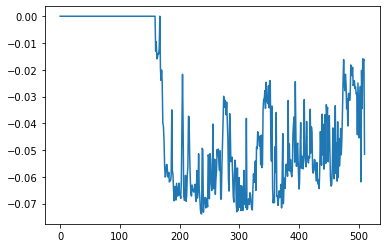

In [27]:
plt.plot(np.arange(eigenvector.shape[0]),eigenvector[:,0])
plt.show()

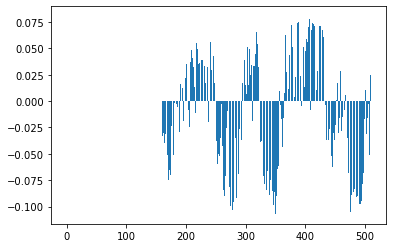

In [42]:

plt.bar(np.arange(len(eigenvector[:,1])), eigenvector[:,1])
plt.show()

In [17]:
# HIDEN MARKOV MODEL still to have an eye on 
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
remodel.fit(corr_mat)
states = remodel.predict(corr_mat)
states

Fitting a model with 262657 free scalar parameters with only 261121 data points will result in a degenerate solution.


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [58]:
epigen=pd.read_csv("E116_15.bed", sep="\t",header=None)
chr_epigen=epigen.loc[epigen[0] == "chr22"]
chr_epigen

C:\Users\oktaw\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,0,1,2,3
445903,chr22,0,16228200,15
445904,chr22,16228200,16230200,9
445905,chr22,16230200,16350000,15
445906,chr22,16350000,16350400,9
445907,chr22,16350400,16847600,15
...,...,...,...,...
455434,chr22,51212200,51220800,5
455435,chr22,51220800,51221000,7
455436,chr22,51221000,51221200,2
455437,chr22,51221200,51222800,1


In [56]:
epigen

,0,1,2,3
0,chr1,0,9800,15
1,chr1,9800,10600,9
2,chr1,10600,235600,15
3,chr1,235600,236000,7
4,chr1,236000,713200,15
...,...,...,...,...
466765,chrX,155226800,155227000,7
466766,chrX,155227000,155227400,2
466767,chrX,155227400,155228200,7
466768,chrX,155228200,155270400,15


In [67]:
# selecting contactcts  having particular epigenic mark from [0,15]
chr_mark=chr_epigen.loc[chr_epigen[3] == "15"]
chr_mark


,0,1,2,3
445903,chr22,0,16228200,15
445905,chr22,16230200,16350000,15
445907,chr22,16350400,16847600,15
445913,chr22,16862600,16868600,15
445915,chr22,16871400,17000800,15
...,...,...,...,...
455427,chr22,51160800,51162600,15
455429,chr22,51163000,51175000,15
455431,chr22,51177200,51195400,15
455433,chr22,51196000,51212200,15


(511, 511)

In [19]:
'''''From now not ready yet



# INTRACHROMOSOMAL
ch1=pd.read_csv("chr1_100kb.txt", sep="\t",header=None) # Oktawia , I changed here  acces to data 
A=np.array(ch1)
A=np.int_(A)
print('Input data shape : ',np.shape(A))

ch2=pd.read_csv("chr2_100kb.txt", sep="\t",header=None) # Oktawia , I changed here  acces to data 
B=np.array(ch1)
B=np.int_(B)
print('Input data shape : ',np.shape(A))

#np.array([A[:,1],A[:,0],A[:,2]])
A=np.concatenate((A,np.transpose(np.array([A[:,1],A[:,0],A[:,2]]))), axis=0)
B=np.concatenate((B,np.transpose(np.array([B[:,1],B[:,0],B[:,2]]))), axis=0)



SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-19-b2e138e12d2b>, line 19)

In [ ]:
inter=np.vstack((A,C,B))

In [ ]:
inter.shape

In [ ]:
ch1_2=pd.read_csv("chr1_2_100kb.txt", sep="\t",header=None)
C=np.array(ch1_2)
C=np.int_(C)

In [ ]:
inter= sparse.coo_matrix( (inter[:,2], (inter[:,0],inter[:,1])))

binned_map_inter=HiCtoolbox.bin2d(inter,R,R) #!become csr sparse array

LENTEST=np.shape(inter)[0]
print('Input at the good resolution : ',np.shape(binned_map_inter))

del inter#keep space


In [ ]:

print("before filtering : ",np.shape(binned_map))
sumHicmat=np.sum(binned_map,0) 
mini = np.mean(sumHicmat)-np.std(sumHicmat)*1.5 #min value of filtering
maxi = np.mean(sumHicmat)+np.std(sumHicmat)*1.5 #max value of filtering
binsaved=np.where(np.logical_and(mini < sumHicmat,sumHicmat < maxi)) #coord of bin to save
filtered_map=binned_map[binsaved[1],:] #save on raw
filtered_map=filtered_map[:,binsaved[1]] #save on col

print("after filtering : ",np.shape(filtered_map))



In [ ]:
contact_map=HiCtoolbox.SCN(filtered_map.copy()) 
#contact_map=np.asarray(contact_map)**alpha # ? 


In [ ]:
plt.figure(figsize=(8, 8)) 
sns.heatmap(contact_map, norm=LogNorm())

In [ ]:
# COLORS
color=pd.read_csv(EpiGfilename,delimiter='\t',header=None,names=[1,2,3,4])
color=color[color[1]=='chr2']#take only chr of interest
number=color[4].max() #number of color in the file
color_vec=np.zeros((LENTEST,number+1)) #build array at pb resolution LENchr * number of color
i=0
while i<np.shape(color)[0]:
	color_vec[color[2].iloc[i]:color[3].iloc[i],color[4].iloc[i]]=1
	i+=1

color_bins=HiCtoolbox.bin2d(color_vec,R,1)
color_bins=color_bins/np.amax(color_bins)

print('Bp cover by this mark, has to be >0 :',np.sum(color_bins[:,selectedmark]) )

In [ ]:
#3D

In [ ]:
#3D
print('3D')#Here : sparse int64
contact_map=HiCtoolbox.SCN(filtered_map.copy()) 
contact_map=np.asarray(contact_map)**alpha #now we are not sparse at all
dist_matrix = HiCtoolbox.fastFloyd(1/contact_map) #shortest path on the matrix
dist_matrix=dist_matrix-np.diag(np.diag(dist_matrix))#remove the diagonal
dist_matrix=(dist_matrix+np.transpose(dist_matrix))/2;

In [ ]:
#MDS
embedding = MDS(n_components=3)#LOAD the MDS #With scikit-learn mds
XYZ = embedding.fit_transform(dist_matrix) #Make the transform
XYZ=np.float64(XYZ)
XYZ,E=HiCtoolbox.sammon(dist_matrix, 3)#with the one from tom j pollard


In [ ]:
hull=ConvexHull(XYZ)
scale=100/hull.area**(1/3)
XYZ=XYZ*scale

HiCtoolbox.writePDB('3Dcolors_'+str(alpha)+'.pdb',XYZ,color2)